Upload & Load Dataset

In [ ]:
import pandas as pd
df = pd.read_csv("user_product_interactions.csv")
df.head()


,user_id,product_id,product_name,interaction_type,timestamp
0,1,101,Wireless Mouse,view,2024-01-05
1,1,102,Mechanical Keyboard,purchase,2024-01-06
2,1,103,Gaming Headset,view,2024-01-07
3,2,101,Wireless Mouse,add_to_cart,2024-01-08
4,2,104,USB-C Hub,purchase,2024-01-09


 Data Preprocessing

In [ ]:
# Convert timestamps to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Convert interaction types into numerical weights
interaction_weights = {"view": 1, "add_to_cart": 2, "purchase": 3}
df["interaction_value"] = df["interaction_type"].map(interaction_weights)

# Show processed data
df.head()


,user_id,product_id,product_name,interaction_type,timestamp,interaction_value
0,1,101,Wireless Mouse,view,2024-01-05,1
1,1,102,Mechanical Keyboard,purchase,2024-01-06,3
2,1,103,Gaming Headset,view,2024-01-07,1
3,2,101,Wireless Mouse,add_to_cart,2024-01-08,2
4,2,104,USB-C Hub,purchase,2024-01-09,3


Create User-Product Matrix

In [ ]:
# Create a User-Product interaction matrix
user_product_matrix = df.pivot_table(index="user_id", columns="product_id", values="interaction_value", aggfunc="sum", fill_value=0)

# Display matrix
user_product_matrix.head()


product_id,101,102,103,104,105,106,107
user_id,,,,,,,
1,1,3,1,0,0,0,0
2,2,0,0,3,0,0,0
3,0,3,0,0,1,0,0
4,0,0,0,0,0,1,0
5,0,0,0,3,0,0,3


Train the AI Recommendation Model

In [ ]:
from sklearn.neighbors import NearestNeighbors
import joblib

# Train the recommendation model
recommendation_model = NearestNeighbors(n_neighbors=3, metric='cosine')
recommendation_model.fit(user_product_matrix)

# Save the trained model
joblib.dump(recommendation_model, "recommendation_model.joblib")
joblib.dump(user_product_matrix, "user_product_matrix.joblib")

print(" Recommendation Model Trained and Saved!")


 Recommendation Model Trained and Saved!


Test the Recommendation Model

In [ ]:
def get_recommendations(user_id):
    # Load trained model & user-product matrix
    model = joblib.load("recommendation_model.joblib")
    user_product_matrix = joblib.load("user_product_matrix.joblib")

    # Load the dataset again to fetch product names
    df = pd.read_csv("user_product_interactions.csv")

    # Check if user exists in dataset
    if user_id not in user_product_matrix.index:
        return "User ID not found."

    # Find similar users
    user_index = user_product_matrix.index.get_loc(user_id)
    distances, indices = model.kneighbors([user_product_matrix.iloc[user_index]])

    # Get recommended product IDs based on similar users
    recommended_users = user_product_matrix.iloc[indices[0]].index.tolist()
    recommended_products = []
    for rec_user in recommended_users:
        recommended_products.extend(user_product_matrix.loc[rec_user][user_product_matrix.loc[rec_user] > 0].index.tolist())

    # Remove duplicates
    recommended_products = list(set(recommended_products))

    # Fetch product names from the dataset
    product_info = df[df['product_id'].isin(recommended_products)][['product_id', 'product_name']].drop_duplicates()

    # Convert to list of dictionaries
    recommendations = product_info.to_dict(orient="records")

    return recommendations

# Test with a user
test_user = 1
print(f"Recommended products for User {test_user}: {get_recommendations(test_user)}")


Recommended products for User 1: [{'product_id': 101, 'product_name': 'Wireless Mouse'}, {'product_id': 102, 'product_name': 'Mechanical Keyboard'}, {'product_id': 103, 'product_name': 'Gaming Headset'}, {'product_id': 105, 'product_name': 'Smartwatch'}]


Train Future Sales Prediction Model

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Aggregate product purchases over time
df_sales = df[df["interaction_type"] == "purchase"]
sales_data = df_sales.groupby(["timestamp", "product_id"])["interaction_value"].sum().unstack(fill_value=0)

# Convert timestamps to numerical format
sales_data["days"] = (sales_data.index - sales_data.index.min()).days

# Train a demand prediction model
X = sales_data["days"].values.reshape(-1, 1)
y = sales_data.mean(axis=1).values  # Average sales per day

# Fit Linear Regression Model
demand_model = LinearRegression()
demand_model.fit(X, y)

# Save model
joblib.dump(demand_model, "demand_model.joblib")
print(" Demand Prediction Model Trained and Saved!")


 Demand Prediction Model Trained and Saved!


Visualize Future Sales Trends

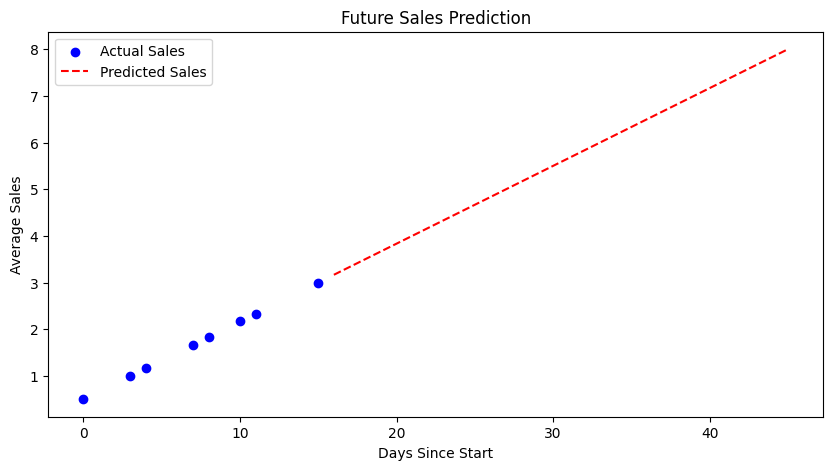

In [ ]:
# Predict next 30 days
future_days = np.arange(X.max() + 1, X.max() + 31).reshape(-1, 1)
future_sales = demand_model.predict(future_days)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='blue', label='Actual Sales')
plt.plot(future_days, future_sales, color='red', linestyle="dashed", label='Predicted Sales')
plt.xlabel("Days Since Start")
plt.ylabel("Average Sales")
plt.title("Future Sales Prediction")
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save trained models to Google Drive
joblib.dump(recommendation_model, "/content/drive/My Drive/recommendation_model.joblib")
joblib.dump(user_product_matrix, "/content/drive/My Drive/user_product_matrix.joblib")

print(" Models saved successfully in Google Drive!")


Mounted at /content/drive
 Models saved successfully in Google Drive!
